## Calculate wind stress curl, Ekman pumping, and integrated vertical velocity to compare with isopycnal variability

### This notebook accounts for the presence/absence of sea ice while calculating wind stress curl and $w_{ek}$

When sea ice is present, wind stress is zero (e.g., fast ice along Melville Bay coastline buffers ocean from wind forcing). <br>
When there is open water (sea ice conc < 50%) wind causes a drag force on ocean surface.<br>
**I will be trying different thresholds for 'open water' - 15% to 50%**

In [1]:
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import numpy as np
import pandas as pd
import xarray as xr
import math

In [2]:
# import daily averaged sea ice data for Baffin Bay (flagged data already masked)
input_dir = Path('C:/Users/marie/Documents/PhD/Chapter_3/data/era5/sea_ice/daily')
seaice_1d_2018to2020 = xr.open_dataset(input_dir / "seaice_2018to2020_1d.nc")

In [3]:
# import daily averaged wind stress data for Baffin Bay
input_dir = Path('C:/Users/marie/Documents/PhD/Chapter_3/data/era5/wind/daily')
tau_1d_2018to2020 = xr.open_dataset(input_dir / "tau_1d_2018to2020.nc")

### We want to set wind stress = 0 when sea ice conc > 50% and compute wind stress curl and vertical velocity, $w_{ek}$

(1) Mask wind stress values (tau=0) when sea ice conc > 50%

In [4]:
# mask tau 2018-2020 data to isolate only open ocean wind stress (i.e., apply 0 to instances when the area is covered with sea ice)
# the dims and grid cells are the same for these two datasets
tau_x_1d_2018to2020_openocean = tau_1d_2018to2020.iews.where(seaice_1d_2018to2020.siconc < 0.50, 0)
tau_y_1d_2018to2020_openocean = tau_1d_2018to2020.inss.where(seaice_1d_2018to2020.siconc < 0.50, 0)

(2) Mask grid cells (zero) that have > 20% land cover (i.e., isolate ocean grid cells)

In [5]:
# now zero grid cells that have > 20% land cover
tau_x_1d_2018to2020_ocean_masked = tau_x_1d_2018to2020_openocean.where(tau_1d_2018to2020.lsm < 0.2, 0)
tau_y_1d_2018to2020_ocean_masked = tau_y_1d_2018to2020_openocean.where(tau_1d_2018to2020.lsm < 0.2, 0)

### Now calculate wind stress curl and Ekman pumping

In [6]:
# calculate deltas: ∂τy/∂x - ∂τx/∂y

# reverse order of latitude coordinate since it is in decreasing order and we need increasing (northward)
tau_x_1d_ocean = tau_x_1d_2018to2020_ocean_masked.reindex(latitude=list(reversed(tau_x_1d_2018to2020_ocean_masked.latitude)))
tau_y_1d_ocean = tau_y_1d_2018to2020_ocean_masked.reindex(latitude=list(reversed(tau_y_1d_2018to2020_ocean_masked.latitude)))

# ∂τy (northward component) - change in y component wind stress in the x direction
delta_tau_y_1d = tau_y_1d_ocean.diff(dim='longitude',label='lower')
# ∂τx (eastward component) - change in x component wind stress in the y direction
delta_tau_x_1d = tau_x_1d_ocean.diff(dim='latitude',label='lower')

# need to calculate approximate length of each grid cell in meters
# there are ~111.11 km per 1 deg latitude and each grid cell is 0.25 degrees latitude = 27.75 km
# longitude grid cell in meters can be approximated as latitude*4: (cos(latitude) = cos(75.5 deg) = 0.25; 1/0.25 = 4; 4*lat = lon)
delta_x = 6944 # each grid square is 0.25 deg lon = 27.8 km/4 = 6,944 m
delta_y = 27778 # 0.25 deg latitude = 27.75 km = 27,778 m

# calculate wind stress curl
curl_1d = (delta_tau_y_1d/delta_x) - (delta_tau_x_1d/delta_y)

### Scale wind stress grid cells by percent sea ice (wind stress curl/(1-SI%)) <br>
This will increase wind stress curl at sea ice edge/front

In [7]:
# mask sea ice dataset for when sea ice is > 15%
seaice_1d_2018to2020_masked = seaice_1d_2018to2020.siconc.where(seaice_1d_2018to2020.siconc < 0.50, 0)

In [8]:
# scale wind stress curl by open water area (1-SI)
curl_1d_scaled = curl_1d / (1 - seaice_1d_2018to2020_masked)

Sanity check: compare wind stress value before and after it was scaled

In [9]:
print("curl before scaling: ", curl_1d.sel(time='2019-11-20', longitude=-60, latitude=75).values)
print("sea ice conc: ", seaice_1d_2018to2020.siconc.sel(time='2019-11-20', longitude=-60, latitude=75).values)
print("curl after scaling: ", curl_1d_scaled.sel(time='2019-11-20', longitude=-60, latitude=75).values)

curl before scaling:  7.8149804e-07
sea ice conc:  0.007209778
curl after scaling:  7.871734e-07


## Calculate ekman pumping, $w_{ek}$

In [9]:
coriolis = 2*(7.2921e-5)*math.sin(75*math.pi/180) # s^−1
rho = 1027 # kg/m^3

In [10]:
## calculate Ekman pumping in Baffin Bay
## w_ek = curl/ρf
w_ek = curl_1d_scaled/(rho*coriolis)

In [11]:
# take monthly mean
w_ek_12month = w_ek.groupby('time.month').mean(dim='time') # takes monthly mean (n=12)
w_ek_monthly = w_ek.resample(time="1M").mean() # samples each consecutive month (n=36)

In [12]:
# estimate vertical transport per day (original units were m/sec)
# 86400 seconds per day

w_ek_m_perday = w_ek*86400
w_ek_12month_m_perday = w_ek_12month*86400
w_ek_monthly_m_perday = w_ek_monthly*86400

## Integrate vertical velocity and compare with isopycnal variability

In [13]:
## subset data for each grid cell closest to mooring

ekman_KO = w_ek_m_perday.sel(latitude = 75.75, longitude = -60)
curl_KO  = curl_1d_scaled.sel(latitude = 75.75, longitude = -60)
ice_KO   = seaice_1d_2018to2020.sel(latitude = 75.75, longitude = -60)

ekman_sverdrup = w_ek_m_perday.sel(latitude = 75.5, longitude = -59)
curl_sverdrup  = curl_1d_scaled.sel(latitude = 75.5, longitude = -59)
ice_sverdrup   = seaice_1d_2018to2020.sel(latitude = 75.5, longitude = -59)

ekman_rink = w_ek_m_perday.sel(latitude = 76, longitude = -61.25)
curl_rink  = curl_1d_scaled.sel(latitude = 76, longitude = -61.25)
ice_rink   = seaice_1d_2018to2020.sel(latitude = 76, longitude = -61.25)

ekman_fisher = w_ek_m_perday.sel(latitude = 76, longitude = -61.75)
curl_fisher  = curl_1d_scaled.sel(latitude = 76, longitude = -61.75)
ice_fisher   = seaice_1d_2018to2020.sel(latitude = 76, longitude = -61.75)

# sea ice N Baffin Bay
ice_baffinbay_1d = seaice_1d_2018to2020.sel(longitude=slice(-70,-65), latitude=slice(75,73))
ice_baffinbay_1d_avg = ice_baffinbay_1d.mean(dim=['latitude','longitude'])

#### Integrate vertical velocity

In [14]:
def integrate_vertical_velocity(ekman_da):
    ekman_integral = []
    # https://numpy.org/doc/stable/reference/generated/numpy.trapz.html#r7aa6c77779c0-2
    for i in range(len(ekman_da.time.values)):
        integral_tmp = np.trapz(ekman_da.isel(time=slice(i,i+2)).values, dx=1)
        ekman_integral.append(integral_tmp)
    return ekman_integral[:-1] # remove the last value because it is only running the trapz function with one value (the last i in the loop) and returning zero

In [15]:
vertical_motion_KO     = integrate_vertical_velocity(ekman_KO)
vertical_motion_sver   = integrate_vertical_velocity(ekman_sverdrup)
vertical_motion_rink   = integrate_vertical_velocity(ekman_rink)
vertical_motion_fisher = integrate_vertical_velocity(ekman_fisher)

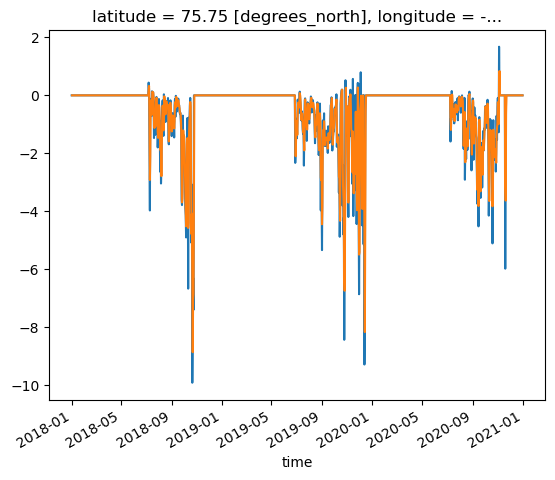

In [74]:
ekman_KO.plot()
plt.plot(ekman_KO.time.values[1:], vertical_motion_KO)

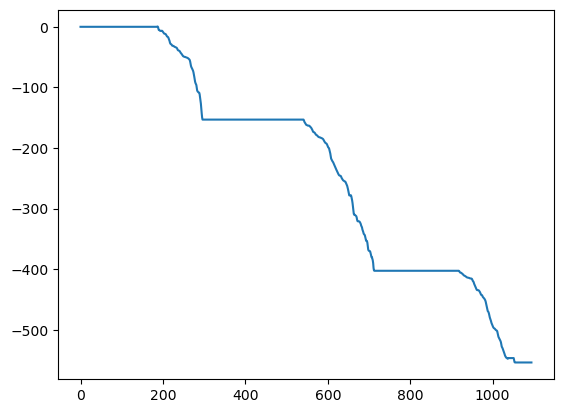

In [75]:
plt.plot(np.cumsum(vertical_motion_KO))

### Model integrated vertical velocity to match isopycnal variation

In [30]:
## dh/dt = vertical motion + relaxing term
## dh/dt = vertical motion + (-h/tau)
## h_(t+1) = h_t + delta_t*dh/dt

dt = 1 # 1 day
tau = 30 # number of days for relaxation period
h = [0] # initial = 0 
    
for i in range(1,len(ekman_KO)):
    dh_dt = ekman_KO.values[i] + (-h[i-1]/tau)
    h.append(h[i-1] + dh_dt*dt) # calculate delta h for each timestep

### Extract isopyncal from mooring profile and plot together

In [32]:
profile_interp_ds_dir = 'C:/Users/marie/Documents/PhD/Chapter_3/data/OMG_Narwhals_mooring_data/OMG_Narwhals_mooring_interpolated/'

KO_density_ds = xr.open_dataset(profile_interp_ds_dir + 'OMG_Narwhals_Mooring_KongOscar_1D_interpolated_density_profile.nc')
KO_temp_ds    = xr.open_dataset(profile_interp_ds_dir + 'OMG_Narwhals_Mooring_KongOscar_1D_interpolated_temp_profile.nc')

In [33]:
# function that extracts isotherm or isopycnal
def find_iso(array, target_iso_val):
    iso = []
    for i in range(len(array.time.values)):
        if len(np.unique(array.isel(time=i).values))==1:
            iso_depth_tmp = np.nan
        else:
            idx = np.nanargmin((np.abs(array.isel(time=i).values - target_iso_val)))
            if idx==0: iso_depth_tmp = np.nan
            else:
                iso_depth_tmp = array.isel(time=i).depth.values[idx]
        
        iso.append(iso_depth_tmp)
    return iso

In [34]:
ko_isopycnal = find_iso(KO_density_ds.density, 27.65)
ko_isotherm  = find_iso(KO_temp_ds.temperature, -0.4)

In [35]:
from matplotlib.lines import Line2D

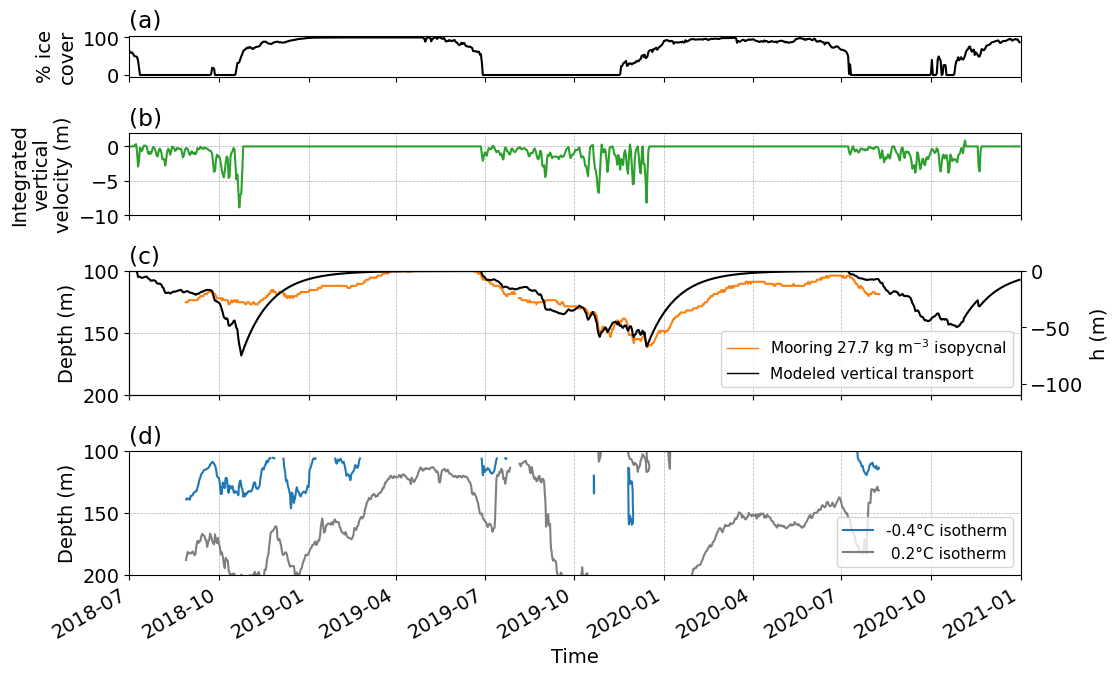

In [42]:
plt.rcParams['font.size'] = '14'
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1,figsize=(11.5,7), sharex=True,\
                                      gridspec_kw={'height_ratios': [1, 2, 3, 3]})
plt.subplots_adjust(hspace=0.6)

# plot sea ice and vertical motion in meters
ax1.plot(ice_KO.time.values, ice_KO.siconc*100, color='k')
ax2.plot(ekman_KO.time.values[1:], vertical_motion_KO, color='tab:green')

# plot isopycnal and output from 1-dim ODE
ax3.plot(KO_density_ds.time.values,np.array(ko_isopycnal)-20,color='tab:orange')
ax3_twin = ax3.twinx()  
ax3_twin.plot(ekman_KO.time.values,h,color='k')
# add legend
custom_lines = [Line2D([0], [0], color='tab:orange', lw=1),
                Line2D([0], [0], color='k', lw=1)]
ax3.legend(custom_lines, ['Mooring 27.7 kg m$^{-3}$ isopycnal', 'Modeled vertical transport'],\
           loc='lower right',prop={'size': 11})

# plot isotherm to compare
KO_temp_ds.temperature.plot.contour(ax=ax4,levels=[-0.4],linestyles='solid',colors='tab:blue')
KO_temp_ds.temperature.plot.contour(ax=ax4,levels=[0.2],linestyles='solid',colors='tab:gray')
# add legend
custom_lines = [Line2D([0], [0], color='tab:blue', lw=1.5),
                Line2D([0], [0], color='tab:gray', lw=1.5)]
ax4.legend(custom_lines, ['-0.4°C isotherm', ' 0.2°C isotherm'], loc='lower right',prop={'size': 11})

ax1.set_ylabel("% ice\ncover")
ax2.set_ylabel("Integrated\nvertical\nvelocity (m)")
ax3.set_ylabel("depth (m)")
ax3_twin.set_ylabel("h (m)")
ax3.set_ylabel("Depth (m)")
ax4.set_ylabel("Depth (m)")
ax4.set_xlabel("Time")

ax1.set_xlim(np.datetime64("2018-07-01"),np.datetime64("2021-01-01"))
ax2.set_ylim(-10,2)
ax2.set_yticks([-10,-5,0])
ax3.set_ylim(200,100)
ax3_twin.set_yticks([0,-50,-100])
ax4.set_ylim(200,100)
ax3_twin.set_ylim(-110,0)

ax2.grid(linestyle='dashed',linewidth=0.5)
ax3.grid(linestyle='dashed',linewidth=0.5)
ax4.grid(linestyle='dashed',linewidth=0.5)

## add labels to each subplot
ax1.set_title("(a)", loc='left')
ax2.set_title("(b)", loc='left')
ax3.set_title("(c)", loc='left')
ax4.set_title("(d)", loc='left');

plt.savefig("../../../OMG_manuscript_Github/OMG_Narwhals_hydrography-manuscript/Analyses-and-plots/figures/isopycnal_ODE.png",bbox_inches='tight', dpi=300, facecolor='white')